In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from collections import defaultdict
from itertools import combinations, chain
from typing import List, Tuple, Dict
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

#### Step-1: Load the dataset

In [2]:
def load_dataset(path):
    try:
        df=pd.read_csv(path)
        print("Dataset loaded successfully with shape: ", df.shape)
        return df
    except Exception as e:
        print("Error loading dataset: ", e)
        return None

## PART-A: DATA PREPROCESSING

In [3]:
orders=load_dataset('orders.csv')
order_products=load_dataset('order_products__train.csv')
products=load_dataset('products.csv')

# Check if any loading failed
if any(df is None for df in [orders, order_products, products]):
    print("One or more datasets failed to load. Stopping.")
else:
    print("All datasets loaded successfully. Starting preprocessing...")

Dataset loaded successfully with shape:  (3421083, 7)
Dataset loaded successfully with shape:  (1384617, 4)
Dataset loaded successfully with shape:  (49688, 4)
All datasets loaded successfully. Starting preprocessing...


In [4]:
# --- Filter for 'train' eval_set orders ---
train_orders = orders[orders['eval_set'] == 'train']

# --- Merge orders with order_products to get product_ids per order ---
train_data = pd.merge(train_orders[['order_id']], order_products, on='order_id', how='inner')

# --- Group by order_id to get list of products per order ---
transactions = train_data.groupby('order_id')['product_id'].apply(list).tolist()

print(f"Total transactions: {len(transactions)}")
print("Sample transaction:", transactions[0])

Total transactions: 131209
Sample transaction: [49302, 11109, 10246, 49683, 43633, 13176, 47209, 22035]


In [5]:
def split_transactions(transactions: List[List[str]], train_ratio: float = 0.8):
    np.random.seed(42)
    indices = np.arange(len(transactions))
    np.random.shuffle(indices)
    split = int(len(transactions) * train_ratio)
    train = [transactions[i] for i in indices[:split]]
    test = [transactions[i] for i in indices[split:]]
    return train, test

PART B

Loaded 131209 transactions. Training on 104967, testing on 26242
[ALG=fp] min_sup=0.001, min_conf=0.01 => 5431 rules
[ALG=fp] min_sup=0.001, min_conf=0.03 => 4033 rules
[ALG=fp] min_sup=0.001, min_conf=0.05 => 2995 rules
[ALG=fp] min_sup=0.001, min_conf=0.07 => 2134 rules
[ALG=fp] min_sup=0.001, min_conf=0.10 => 1492 rules
[ALG=fp] min_sup=0.002, min_conf=0.01 => 1490 rules
[ALG=fp] min_sup=0.002, min_conf=0.03 => 1327 rules
[ALG=fp] min_sup=0.002, min_conf=0.05 => 1088 rules
[ALG=fp] min_sup=0.002, min_conf=0.07 => 870 rules
[ALG=fp] min_sup=0.002, min_conf=0.10 => 663 rules
[ALG=fp] min_sup=0.003, min_conf=0.01 => 684 rules
[ALG=fp] min_sup=0.003, min_conf=0.03 => 649 rules
[ALG=fp] min_sup=0.003, min_conf=0.05 => 551 rules
[ALG=fp] min_sup=0.003, min_conf=0.07 => 443 rules
[ALG=fp] min_sup=0.003, min_conf=0.10 => 363 rules
[ALG=fp] min_sup=0.005, min_conf=0.01 => 219 rules
[ALG=fp] min_sup=0.005, min_conf=0.03 => 219 rules
[ALG=fp] min_sup=0.005, min_conf=0.05 => 196 rules
[ALG=fp] 

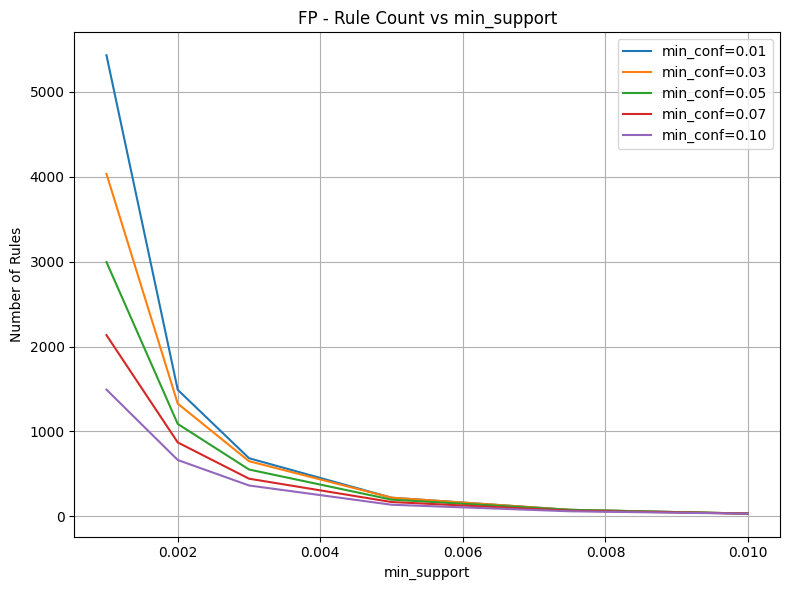

In [6]:
def generate_apriori_rules(freq_itemsets, min_conf, total_txns):
    """
    Generate association rules where:
    - LHS has exactly 1 item
    - RHS can have 1 or more items
    """
    rules = []
    support_data = {itemset: freq / total_txns for itemset, freq in freq_itemsets.items()}

    for itemset in freq_itemsets:
        if len(itemset) < 2:
            continue

        itemset_support = support_data[itemset]
        itemset_list = list(itemset)

        for lhs in itemset:
            A = frozenset([lhs])
            B = itemset - A

            if not B:
                continue

            support_A = support_data.get(A)
            support_B = support_data.get(B)

            if support_A:
                confidence = itemset_support / support_A
                if confidence >= min_conf:
                    lift = confidence / support_data.get(B, 1e-10)  
                    rules.append({
                        "LHS": A,
                        "RHS": B,
                        "Support": round(itemset_support, 4),
                        "Confidence": round(confidence, 4),
                        "Lift": round(lift, 4)
                    })

    return rules


# FP-GROWTH
class FPNode:
    def __init__(self, item, parent):
        self.item = item
        self.count = 1
        self.parent = parent
        self.children = {}
        self.link = None

def build_fp_tree(transactions, min_support_count):
    freq = defaultdict(int)
    for tx in transactions:
        for item in tx:
            freq[item] += 1

    freq = {item: count for item, count in freq.items() if count >= min_support_count}
    if not freq:
        return None, None

    header = {item: None for item in freq}
    root = FPNode(None, None)

    for tx in transactions:
        tx_items = [item for item in tx if item in freq]
        tx_items.sort(key=lambda x: freq[x], reverse=True)

        curr = root
        for item in tx_items:
            if item in curr.children:
                curr.children[item].count += 1
            else:
                new_node = FPNode(item, curr)
                curr.children[item] = new_node
                if header[item] is None:
                    header[item] = new_node
                else:
                    link_node = header[item]
                    while link_node.link:
                        link_node = link_node.link
                    link_node.link = new_node
            curr = curr.children[item]

    return root, header

def mine_fp_tree(header, prefix, freq_itemsets, min_support):
    for item in header:
        new_prefix = prefix.copy()
        new_prefix.add(item)
        count = 0
        node = header[item]
        paths = []
        while node:
            count += node.count
            path = []
            parent = node.parent
            while parent and parent.item:
                path.append(parent.item)
                parent = parent.parent
            if path:
                paths.append((path[::-1], node.count))
            node = node.link

        freq_itemsets[frozenset(new_prefix)] = count

        conditional_tx = []
        for path, cnt in paths:
            conditional_tx.extend([path] * cnt)

        subtree, sub_header = build_fp_tree(conditional_tx, min_support)
        if sub_header:
            mine_fp_tree(sub_header, new_prefix, freq_itemsets, min_support)

# EXPERIMENTATION
def experiment_thresholds(txns, algo='apriori'):
    min_sups = [0.001, 0.002, 0.003, 0.005, 0.0075, 0.01]
    min_confs = [0.01, 0.03, 0.05, 0.07, 0.1]
    total_tx = len(txns)
    results = []

    for ms in min_sups:
        for mc in min_confs:
            min_sup_count = int(ms * total_tx)
            tree, header = build_fp_tree(txns, min_sup_count)
            freq = dict()
            if header:
                mine_fp_tree(header, set(), freq, min_sup_count)
            rules = generate_apriori_rules(freq, mc, total_tx)

            results.append((ms, mc, len(rules)))
            print(f"[ALG={algo}] min_sup={ms:.3f}, min_conf={mc:.2f} => {len(rules)} rules")

    fig = plt.figure(figsize=(8, 6))
    for mc in min_confs:
        y = [r[2] for r in results if r[1] == mc]
        x = [r[0] for r in results if r[1] == mc]
        plt.plot(x, y, label=f"min_conf={mc:.2f}")

    plt.title(f"{algo.upper()} - Rule Count vs min_support")
    plt.xlabel("min_support")
    plt.ylabel("Number of Rules")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{algo}_threshold_experiment.png")
    plt.show()

if __name__ == "__main__":
    orders_path = "orders.csv"
    order_products_path = "order_products__train.csv"
    products_path = "products.csv"

    train_tx, test_tx = split_transactions(transactions)

    print(f"Loaded {len(transactions)} transactions. Training on {len(train_tx)}, testing on {len(test_tx)}")

    experiment_thresholds(train_tx, algo='fp')


PART C

In [32]:
print(f"Loaded {len(transactions)} transactions. Training on {len(train_tx)}, testing on {len(test_tx)}")

# Build FP-tree and Generate Rules for selected threshold
minsup = 0.003
minconf = 0.05

total_tx = len(train_tx)
tree, header = build_fp_tree(train_tx, int(minsup * total_tx))
freq_itemsets = dict()
if header:
    mine_fp_tree(header, set(), freq_itemsets, int(minsup * total_tx))

rules = generate_apriori_rules(freq_itemsets, minconf, total_tx)
print(f"Total rules generated: {len(rules)}")

# Generate Top 100 Rule Lists by Support and Confidence
rule_df = pd.DataFrame(rules, columns=["LHS", "RHS", "Support", "Confidence", "Lift"])

# Sort by support and confidence
top_100_support = rule_df.sort_values(by="Support", ascending=False).head(100)
top_100_confidence = rule_df.sort_values(by="Confidence", ascending=False).head(100)

# Merge to find common rules in both
common_rules = pd.merge(top_100_support, top_100_confidence, on=["LHS", "RHS"], how='inner')
print("\nRules Present in Both Top 100 Lists:")
common_rules_renamed = common_rules.rename(columns={
    "Support_x": "Support (from support list)",
    "Confidence_y": "Confidence (from confidence list)"
})
print(common_rules_renamed[["LHS", "RHS", "Support (from support list)", "Confidence (from confidence list)"]])

# Save Top 100 Rules
TEAM_ID = "11"

def save_rules_pretty(rules_df, filename):
    with open(filename, "w") as f:
        for i, row in enumerate(rules_df.itertuples(index=False), 1):
            lhs = ", ".join(str(x) for x in sorted(row.LHS))
            rhs = ", ".join(str(x) for x in sorted(row.RHS))
            f.write(f"Rule {i}:\n")
            f.write(f"LHS → {{{lhs}}}\n")
            f.write(f"RHS → {{{rhs}}}\n")
            f.write(f"Support: {row.Support:.4f} | Confidence: {row.Confidence:.4f} | Lift: {row.Lift:.4f}\n")
            f.write("-" * 60 + "\n")

save_rules_pretty(
    top_100_confidence, 
    f"{TEAM_ID}_top100RulesByConf.txt"
)
save_rules_pretty(
    top_100_support, 
    f"{TEAM_ID}_top100RulesBySup.txt"
)
print(f"Saved formatted files: {TEAM_ID}_top100RulesByConf.txt and {TEAM_ID}_top100RulesBySup.txt")

Loaded 131209 transactions. Training on 104967, testing on 26242
Total rules generated: 551

Rules Present in Both Top 100 Lists:
        LHS      RHS  Support (from support list)  \
0   (21137)  (13176)                       0.0234   
1   (47209)  (13176)                       0.0184   
2   (21903)  (13176)                       0.0169   
3   (47766)  (24852)                       0.0167   
4   (47626)  (24852)                       0.0163   
5   (16797)  (24852)                       0.0147   
6   (27966)  (13176)                       0.0135   
7   (27966)  (21137)                       0.0126   
8   (26209)  (47626)                       0.0120   
9   (47209)  (21137)                       0.0116   
10  (26209)  (24852)                       0.0102   
11  (39275)  (21137)                       0.0098   
12  (30391)  (13176)                       0.0095   
13  (45066)  (24852)                       0.0094   
14  (28204)  (24852)                       0.0092   
15   (4920)  (24852)  


Generated 551 rules with min_sup=0.003, min_conf=0.05

Precision@1-10: [0.1831, 0.1452, 0.1263, 0.1149, 0.1068, 0.1015, 0.0977, 0.0944, 0.0921, 0.0903]
Recall@1-10: [0.0299, 0.0447, 0.0564, 0.0651, 0.0725, 0.079, 0.0844, 0.088, 0.0915, 0.0947]
F1@1-10: [0.0497, 0.0651, 0.0732, 0.077, 0.0789, 0.0802, 0.0808, 0.0805, 0.0804, 0.0804]


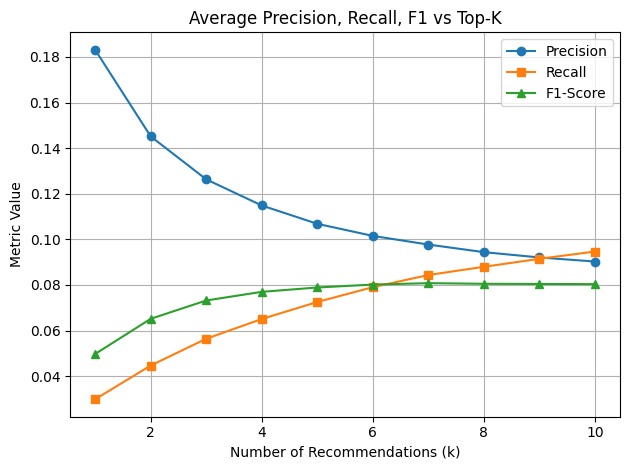


Average Precision (k=10): 0.0903
Average Recall (k=10): 0.0947

Sample Analysis of Test Users:

User 1:
Input items: {34217, 49667, 31461, 3717}
Ground truth: {28879, 45681, 7955, 18205, 44479}
Top-10 Recommended: []
Precision@10: 0.0
Recall@10: 0.0

User 2:
Input items: {41408, 30720, 21479, 15143, 33735, 45066}
Ground truth: {45002, 28785, 10644, 24852, 1942, 48697, 31130}
Top-10 Recommended: [24852, 13176, 21137, 47766, 47626, 21903]
Precision@10: 0.1
Recall@10: 0.1429

User 3:
Input items: {28688, 47626, 16359, 32775}
Ground truth: {43091, 24852, 46870, 4605, 18686}
Top-10 Recommended: [24852, 26209, 47766, 21903, 13176, 21137, 4605, 24964, 45007, 46979]
Precision@10: 0.2
Recall@10: 0.4

User 4:
Input items: {49683, 38291}
Ground truth: {24852, 43310}
Top-10 Recommended: [24852, 47626, 47766]
Precision@10: 0.1
Recall@10: 0.5

User 5:
Input items: {26497, 35336, 47209, 8424, 39275, 19660, 17871}
Ground truth: {21137, 32177, 41588, 7862, 22935, 13176, 14010, 46906}
Top-10 Recommende

In [31]:
def evaluate_rules(rules, test_txns, top_k=10):
    """
    Evaluate rules on test transactions:
    - For each test basket, use first half as input, second half as ground truth
    - Recommend items using rules that match input item
    - Calculate Precision, Recall, F1
    """
    precision_list, recall_list, f1_list = [], [], []
    user_precisions = [[] for _ in range(top_k)]
    user_recalls = [[] for _ in range(top_k)]

    for k in range(1, top_k+1):
        total_prec, total_recall, total_f1, count = 0, 0, 0, 0

        for tx in test_txns:
            tx = list(tx)
            if len(tx) < 2:
                continue

            split = len(tx) // 2
            input_items = set(tx[:split])
            ground_truth = set(tx[split:])

            # Generate candidate recommendations
            candidates = defaultdict(float)
            for rule in rules:
                lhs = rule['LHS']
                rhs = rule['RHS']
                conf = rule['Confidence']

                if lhs.issubset(input_items):
                    for item in rhs:
                        candidates[item] += conf

            ranked_items = sorted(candidates.items(), key=lambda x: -x[1])
            recommended = [item for item, _ in ranked_items[:k]]

            if not recommended:
                continue

            hit = ground_truth.intersection(recommended)
            prec = len(hit) / len(recommended)
            rec = len(hit) / len(ground_truth)
            f1 = 2 * prec * rec / (prec + rec) if prec + rec > 0 else 0

            total_prec += prec
            total_recall += rec
            total_f1 += f1
            count += 1

            user_precisions[k-1].append(prec)
            user_recalls[k-1].append(rec)

        if count > 0:
            precision_list.append(total_prec / count)
            recall_list.append(total_recall / count)
            f1_list.append(total_f1 / count)
        else:
            precision_list.append(0)
            recall_list.append(0)
            f1_list.append(0)

    return precision_list, recall_list, f1_list, user_precisions, user_recalls

def plot_eval_metrics(precision_list, recall_list, f1_list):
    ks = list(range(1, len(precision_list)+1))
    plt.plot(ks, precision_list, label="Precision", marker='o')
    plt.plot(ks, recall_list, label="Recall", marker='s')
    plt.plot(ks, f1_list, label="F1-Score", marker='^')
    plt.xlabel("Number of Recommendations (k)")
    plt.ylabel("Metric Value")
    plt.title("Average Precision, Recall, F1 vs Top-K")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("fp_avg_precision_recall_f1.png")
    plt.show()

    print(f"\nAverage Precision (k=10): {round(precision_list[-1], 4)}")
    print(f"Average Recall (k=10): {round(recall_list[-1], 4)}")

import matplotlib.pyplot as plt
from collections import defaultdict

def sample_user_analysis(rules, test_txns, num_users=5, max_k=10):
    """
    Generate a separate precision and recall plot for each sample user.
    """
    print("\nSample Analysis of Test Users:")
    user_count = 0
    zero_metrics_shown = False

    for tx in test_txns:
        tx = list(tx)
        if len(tx) < 2:
            continue

        split = len(tx) // 2
        input_items = set(tx[:split])
        ground_truth = set(tx[split:])

        # Generate candidate recommendations
        candidates = defaultdict(float)
        for rule in rules:
            if rule['LHS'].issubset(input_items):
                for item in rule['RHS']:
                    candidates[item] += rule['Confidence']

        ranked_items = sorted(candidates.items(), key=lambda x: -x[1])
        all_recommended = [item for item, _ in ranked_items[:max_k]]

        precisions = []
        recalls = []

        for k in range(1, max_k + 1):
            recommended_k = all_recommended[:k]
            hit = ground_truth.intersection(recommended_k)

            precision = len(hit) / k if k > 0 else 0
            recall = len(hit) / len(ground_truth) if ground_truth else 0

            precisions.append(precision)
            recalls.append(recall)

        # Skip if both precision and recall are 0, and one such case already shown
        if sum(precisions) == 0 and sum(recalls) == 0:
            if zero_metrics_shown:
                continue
            else:
                zero_metrics_shown = True

        # Print results for the user
        print(f"\nUser {user_count + 1}:")
        print("Input items:", input_items)
        print("Ground truth:", ground_truth)
        print(f"Top-{max_k} Recommended:", all_recommended[:max_k])
        print(f"Precision@{max_k}:", round(precisions[-1], 4))
        print(f"Recall@{max_k}:", round(recalls[-1], 4))

        # Plot individual graph
        ks = list(range(1, max_k + 1))
        plt.figure()
        plt.plot(ks, precisions, marker='o', label='Precision')
        plt.plot(ks, recalls, marker='s', label='Recall')
        plt.xlabel("Top-K Recommendations")
        plt.ylabel("Metric Value")
        plt.title(f"User {user_count + 1}: Precision & Recall vs K")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f"user_{user_count + 1}_precision_recall.png")
        plt.close()

        user_count += 1
        if user_count >= num_users:
            break



if __name__ == "__main__":
    min_sup = 0.003
    min_conf = 0.05
    min_sup_count = int(min_sup * len(train_tx))

    tree, header = build_fp_tree(train_tx, min_sup_count)
    freq = dict()
    if header:
        mine_fp_tree(header, set(), freq, min_sup_count)

    rules = generate_apriori_rules(freq, min_conf, len(train_tx))
    print(f"\nGenerated {len(rules)} rules with min_sup={min_sup}, min_conf={min_conf}")

    precision_list, recall_list, f1_list, user_precisions, user_recalls = evaluate_rules(
        rules, test_tx, top_k=10
    )

    print("\nPrecision@1-10:", [round(p, 4) for p in precision_list])
    print("Recall@1-10:", [round(r, 4) for r in recall_list])
    print("F1@1-10:", [round(f, 4) for f in f1_list])

    plot_eval_metrics(precision_list, recall_list, f1_list)
    sample_user_analysis(rules, test_tx, num_users=5, max_k=10)
